# Importing Necessary Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder

# Loading Dataset

In [ ]:
(ds_train, ds_test), with_info = tfds.load('mnist',
                                           as_supervised = True,
                                           shuffle_files = True,
                                           with_info = True,
                                           split = ['train','test']
                                           )

# Function to convert Dataset into Numpy array

In [ ]:
def to_numpy_array(dataset_object):

  # Initializing lists to store images and labels
  images = []
  labels = []

  # Loop for storing into a list
  for image,label in tfds.as_numpy(dataset_object):
    images.append(image)
    labels.append(label)

  return np.array(images), np.array(labels).reshape(-1,1)

**Conversion to Numpy array**

In [ ]:
train_images, train_labels = to_numpy_array(ds_train)
test_images, test_labels = to_numpy_array(ds_test)

**Size of the Training and Test Dataset**

In [ ]:
print(f'Training Dataset has the size : {train_images.shape}')
print(f'Training Labels has the size : {train_labels.shape}')
print(f'Test Dataset has the size : {test_images.shape}')
print(f'Test Labels has the size : {test_labels.shape}')

Training Dataset has the size : (60000, 28, 28, 1)
Training Labels has the size : (60000, 1)
Test Dataset has the size : (10000, 28, 28, 1)
Test Labels has the size : (10000, 1)


# Displaying a sample Training set images with their respective labels

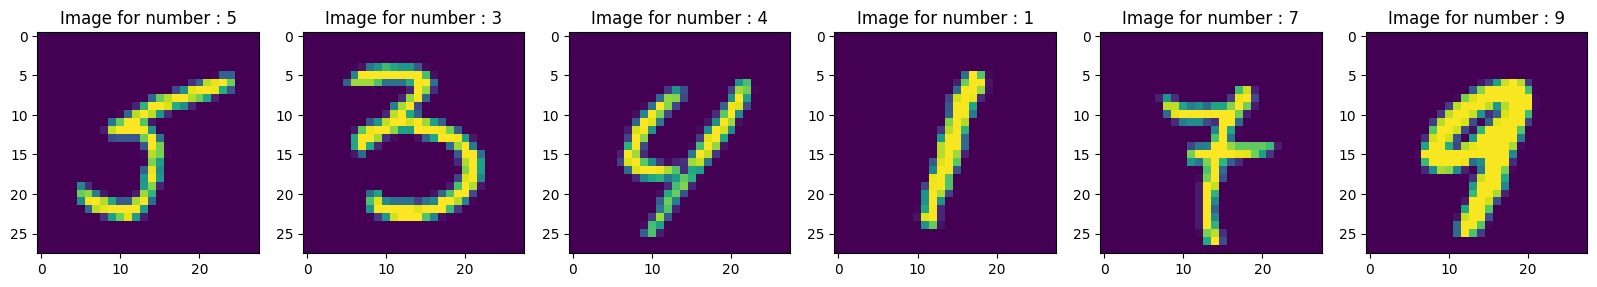

In [ ]:
# Total number of images to be displayed
N = 6
start_img = np.random.randint(low = 1, high = train_images.shape[0]-N, size = 1)[0]
plt.figure(figsize = (20,50))

for i in range(6):
  plt.subplot(1,N,i+1)
  plt.imshow(train_images[start_img + i])
  plt.title (f'Image for number : {train_labels[start_img + i,0]}')

plt.show()

**1-Hot Encoding for the labels**

In [ ]:
# Object for 1-Hot Encoding
one_hot_object = OneHotEncoder(sparse_output = False, categories = 'auto')

# Transformed labels
train_labels = one_hot_object.fit_transform(train_labels)

# Using the same encoder on the test data
test_labels = one_hot_object.transform(test_labels)

In [ ]:
# The dimension for these labels
print(f'Training Labels have the shape : {train_labels.shape}')
print(f'Test Labels have the shape : {test_labels.shape}')

Training Labels have the shape : (60000, 10)
Test Labels have the shape : (10000, 10)


**Reshaping the matrix to be the shape of (Nx,m) for input where m = # of examples, and Nx = total features in the image (all pixels)**

In [ ]:
# For Training set
train_images = train_images.reshape(train_images.shape[0], -1).T
train_labels = train_labels.T

# For test set
test_images = test_images.reshape(test_images.shape[0], -1).T
test_labels = test_labels.T

In [ ]:
# After processing we have the following shapes
print('Revised shape of the Dataset is given as follows:\n\n')
print(f'Training Dataset has the size : {train_images.shape}')
print(f'Training Labels has the size : {train_labels.shape}')
print(f'Test Dataset has the size : {test_images.shape}')
print(f'Test Labels has the size : {test_labels.shape}')

Revised shape of the Dataset is given as follows:


Training Dataset has the size : (784, 60000)
Training Labels has the size : (10, 60000)
Test Dataset has the size : (784, 10000)
Test Labels has the size : (10, 10000)


# **Designing an L-Layer Dense Neural Network**

**Initializing parameters**

In [ ]:
def initialize_parameters(layer_dims: list[int]) -> dict:

  # To store parameters
  parameters = {}

  L = len(layer_dims)

  # A loop for each layer parameter initialization
  for idx in range(1,L):

    # Weights and biases
    parameters['W'+str(idx)] = np.random.randn(layer_dims[idx], layer_dims[idx-1]) * 0.01
    parameters['b'+str(idx)] = np.zeros((layer_dims[idx],1))

  return parameters

In [ ]:
# Initializing parameters
layer_dims = [train_images.shape[0],128,10]
parameters = initialize_parameters(layer_dims)

# Activation function defined

In [ ]:
def relu(x):
  return np.maximum(0,x)

def sigmoid(x):
  return (1/(1+(np.exp(-x))))

def tanh(x):
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))

def softmax(x):
  exponent = np.exp(x - x.max())
  return exponent / np.sum(exponent)

# Derivatives for Activation function

In [ ]:
def diff_relu(x):
  return np.where(x > 0,1,0)

**Cost Function**

In [ ]:
def compute_cost(pred, labels):

  # Total number of examples
  m = labels.shape[-1]

  # A small number to ensure NO NaN
  epsilon = 1e-10

  return - (np.sum(labels * np.log(pred + epsilon))) / m

**Derivative of the Cost Function**

In [ ]:
# This is the derivative of Loss function with respect to Z [i-e dL/dZ] with softmax activation function (Multi-Class Problem)
def diff_cost_softmax (pred, labels):
  return pred - labels

**Computing Accuracy**

In [ ]:
def compute_accuracy(pred, labels):

  # Comparing predictions to labels
  compared_vector = np.argmax(pred, axis = 0) == np.argmax(labels, axis = 0)

  return np.count_nonzero(compared_vector) / len(compared_vector)

# **Forward Propagation**

In [ ]:
def forward_propagation(parameters: dict, num_layers: int, train_images)-> dict:

  cache = {}

  # 'A0' being the input image
  cache['A0'] = A = train_images

  # Loop for all layers forward prop except the OUTPUT LAYER
  for idx in range(1,num_layers):
    cache['Z'+str(idx)] = np.dot(parameters['W'+str(idx)], cache['A'+str(idx - 1)]) + parameters['b'+str(idx)]

    # Softmax for the final layer
    if idx == num_layers:
      cache['A'+str(idx)] = softmax(cache['Z'+str(idx)])

    else:
      cache['A'+str(idx)] = relu(cache['Z'+str(idx)])

  return cache

In [ ]:
cache = forward_propagation(parameters, len(layer_dims), train_images)

# **Backward Propagation**

In [ ]:
"""Back prop implementation for each unit"""
def simple_back_prop(cache: dict, num_layers: int , activation: str, train_labels, dA_residue = None):

  # Total number of training examples
  m = train_labels.shape[-1]

  # Back propagation computations
  if activation  == 'softmax':
    dZ = diff_cost_softmax(cache['A' + str(num_layers)], train_labels)

  elif activation == 'relu':
    dZ = diff_relu(cache['Z' + str(num_layers)]) * dA_residue

  dW = np.dot(dZ, cache['A' + str(num_layers-1)].T) / m

  dB = np.sum(dZ, axis = 1, keepdims = True) / m

  dA_prev = np.dot(parameters['W' + str(num_layers)].T, dZ)

  return (dW, dB, dA_prev)

**Back Propagation for the entire network using the single layer function**

In [ ]:
def backward_propagation(cache: dict, num_layers : int, train_labels):

  # Initializing back propagation parameters
  backprop_param = {}

  # Backpropagation for the entire network (All Layers)
  for idx in range(num_layers , 0, -1):

    # For the output layer
    if idx == num_layers:
      backprop_param ['dW' + str(idx)], backprop_param ['db' + str(idx)], backprop_param['dA' + str(idx-1)] = simple_back_prop(cache, idx, 'softmax', train_labels)

    else:
      backprop_param['dW' + str(idx)], backprop_param ['db' + str(idx)], backprop_param['dA' + str(idx-1)] = simple_back_prop(cache, idx, 'relu', train_labels, backprop_param['dA' + str(idx)])

  return backprop_param

**Verifying the Dimensions after Back Propagation step**

In [ ]:
# Verifying the dimensions of the recorded parameters after back propagation
print('After Back propagation, we have : \n')
num_layers = len(layer_dims)

# To verify the working of back propagation step and the dimension it returns
backprop_param = backward_propagation (cache, num_layers-1,train_labels)

for idx in range(1, num_layers):
    # For Bias
    print(f'\nDimension of B{idx} : {backprop_param["db" + str(idx)].shape}')

    # For Weights
    print(f'Dimension of W{idx} : {backprop_param["dW" + str(idx)].shape}')

    # For Activation function outputs
    print(f'Dimension of A{idx-1} : {backprop_param["dA" + str(idx-1)].shape}')


After Back propagation, we have : 


Dimension of B1 : (128, 1)
Dimension of W1 : (128, 784)
Dimension of A0 : (784, 60000)

Dimension of B2 : (10, 1)
Dimension of W2 : (10, 128)
Dimension of A1 : (128, 60000)


# **Training the Neural Network**




In [ ]:
# Hyperparameters definition
num_epochs = 1000
learning_rate = 0.001

# Counting number of Epochs
num_executed_epoch = 0

# To store the parameters
train_acc_list = []
valid_acc_list = []
train_cost_list = []
valid_cost_list = []

# For Early stopping we declare a parameter to cascade our window
callback_ref_param = np.Inf
num_bad_epoch = 0
patience = 50

# Loop to train them for all epochs
for epoch in range(num_epochs):

  # Forward Propagation for training Data
  fwd_cache = forward_propagation(parameters, num_layers, train_images)

  # Computed Predictions
  predictions = fwd_cache['A' + str(num_layers - 1)]

  """Training set parameters"""
  # Cost Function
  cost = compute_cost(predictions, train_labels)

  # Computing accuracy
  accuracy = compute_accuracy(predictions, train_labels)

  """Validation set parameters"""
  # Forward Propagation for prediction of Validation Dataset
  valid_cache = forward_propagation(parameters, num_layers, test_images)

  # Predictions
  valid_predict = valid_cache['A' + str(num_layers - 1)]

  # Cost Function
  valid_cost = compute_cost(valid_predict, test_labels)

  # Computing accuracy
  valid_acc = compute_accuracy(valid_predict, test_labels)

  # Backward Propagation
  backprop_param = backward_propagation(fwd_cache, num_layers - 1, train_labels)

  # Updating the weights and biases for all layers
  for idx in range(1, num_layers):

    # Updating weights
    parameters['W' + str(idx)] -= learning_rate * backprop_param['dW' + str(idx)]
    #print(f'W + {str(idx)} : {parameters["W" + str(idx)]}')

    # Updating biases
    parameters['b' + str(idx)] -= learning_rate * backprop_param['db' + str(idx)]
    #print(f'b + {str(idx)} : {parameters["b" + str(idx)]}')

  # Displaying Verbose
  print(f'\nEpoch {epoch + 1} of {num_epochs} ------------ Training Cost : {cost:.2f}, Training Accuracy : {accuracy:.2%}, ------ Validation Cost : {valid_cost:.2f}, Validation Accuracy {valid_acc:.2%}')

  # Logging training parameters
  num_executed_epoch += 1

  # Training and Validation accuracy
  train_acc_list.append(accuracy)
  valid_acc_list.append(valid_acc)

  # Training and Validation Loss
  train_cost_list.append(cost)
  valid_cost_list.append(valid_cost)

  # Start recording once the Validation accuracy is less then the prev one
  if valid_cost < callback_ref_param:

    callback_ref_param = valid_cost
    num_bad_epoch = 0

  else:
      # Incrementing the epoch
      num_bad_epoch += 1

      if num_bad_epoch == patience:

        # Stops the training
        print('\n\nEarly Stopping')
        print(f'Validation Cost has not decreased for the past {patience} epochs')
        break



Epoch 1 of 1000 ------------ Training Cost : 14.54, Training Accuracy : 7.68%, ------ Validation Cost : 14.37, Validation Accuracy 7.03%

Epoch 2 of 1000 ------------ Training Cost : 20.79, Training Accuracy : 9.07%, ------ Validation Cost : 20.84, Validation Accuracy 8.96%

Epoch 3 of 1000 ------------ Training Cost : 11.64, Training Accuracy : 12.30%, ------ Validation Cost : 11.67, Validation Accuracy 12.18%

Epoch 4 of 1000 ------------ Training Cost : 23.03, Training Accuracy : 9.87%, ------ Validation Cost : 23.03, Validation Accuracy 9.80%

Epoch 5 of 1000 ------------ Training Cost : 8.44, Training Accuracy : 13.12%, ------ Validation Cost : 8.32, Validation Accuracy 13.21%

Epoch 6 of 1000 ------------ Training Cost : 23.03, Training Accuracy : 9.87%, ------ Validation Cost : 23.03, Validation Accuracy 9.80%

Epoch 7 of 1000 ------------ Training Cost : 17.58, Training Accuracy : 16.80%, ------ Validation Cost : 17.48, Validation Accuracy 16.90%

Epoch 8 of 1000 ------------ 

# Plotting Curves

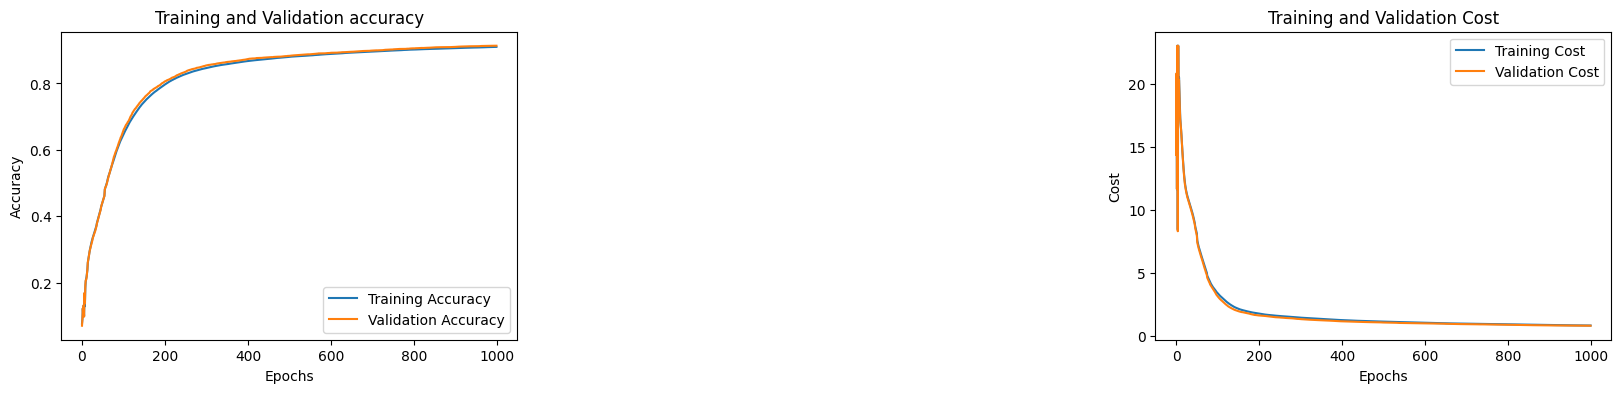

In [ ]:
# Training and Validation Accuracy
epochs = range(num_executed_epoch)

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_acc_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.plot(epochs, valid_acc_list)
plt.legend(['Training Accuracy', 'Validation Accuracy'])

# Plotting for Training and Validation Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, train_cost_list)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training and Validation Cost')
plt.plot(epochs, valid_cost_list)
plt.legend(['Training Cost', 'Validation Cost'])

plt.show()
